### Experimations on positive, negative min and negative max $\delta$s

In [10]:
import random
import numpy as np
import jams
import glob
from utils import update_stats

# set parameters
data_path = "/ldaphome/atiam-1005/music-structure-estimation/data/Isophonics/"
tracks = glob.glob(data_path+"audio/*.mp3")
tracks = [t.replace(data_path+"audio/", '').replace('.mp3','') for t in tracks]
delta_p = np.arange(1, 20, 2)
delta_n = np.arange(4, 36, 2)
n_anchors = 10
num_trials = n_anchors * len(tracks)
fp_vec = np.zeros_like(delta_p)
fn_matrix = np.zeros((len(delta_n), len(delta_n)))


# compute for each track
for k, track in enumerate(tracks) :
    print("track n°" + str(k + 1) + "/" + str(len(tracks)))
    track_annotations = jams.load(data_path + "references/" + track + ".jams")
    annotation_seg = track_annotations.search(namespace='segment_open')[0].data
    boundaries = [obs.time for obs in annotation_seg]
    duration = track_annotations.file_metadata.duration
    fp_vec, fp_matrix = update_stats(n_anchors, fp_vec, fn_matrix, boundaries, duration, delta_p, delta_n)

# for plotting issues
fn_matrix[fn_matrix==0] = 0.5*num_trials


In [11]:
import torch
print(torch.version.cuda)

None


### False Positive and False Negative plots

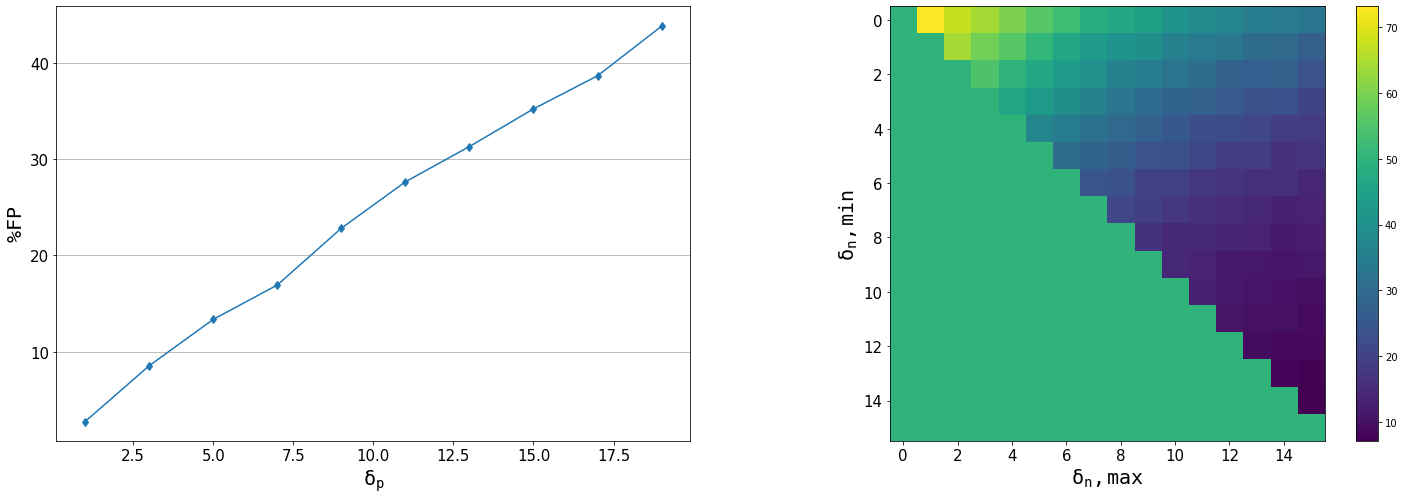

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
plt.plot(delta_p, fp_vec*100/(n_anchors * len(tracks)), '-d')
plt.xlabel('$\mathtt{\delta_p}$', fontsize=20)
plt.ylabel('$\mathtt{\%FP}$', fontsize=20)
plt.grid(axis='y')
plt.tick_params('both', labelsize=15)

plt.subplot(1,2,2)
plt.imshow(fn_matrix*100/num_trials)
plt.colorbar()
plt.xlabel('$\mathtt{\delta_n,max}$', fontsize=20)
plt.ylabel('$\mathtt{\delta_n,min}$', fontsize=20)
plt.tick_params('both', labelsize=15)

### ConvNet for learning audio learning


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_same_pad import get_pad

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        kernel_conv = (4, 6)
        self.pad1 = get_pad((72, 512), kernel_conv)
        self.conv1 = nn.Conv2d(1, 64, kernel_conv)
        self.bnc1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 4))
        self.pad2 = get_pad((36,128), kernel_conv)
        self.conv2 = nn.Conv2d(64, 128, kernel_conv)
        self.bnc2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 4))
        self.pad3 = get_pad((12,32), kernel_conv)
        self.conv3 = nn.Conv2d(128, 256, kernel_conv)
        self.bnc3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 4))
        self.fc1 = nn.Linear(6 * 8 * 256, 128)
        self.bnf1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128)
        self.bnf2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 128)
        self.bnf3 = nn.BatchNorm1d(128)

    def apply_cnn(self,x):
        x = x.unsqueeze(1) # for 1 channel
        x = self.pool1(self.bnc1(F.relu(self.conv1(F.pad(x,self.pad1)))))
        x = self.pool2(self.bnc2(F.relu(self.conv2(F.pad(x,self.pad2)))))
        x = self.pool3(self.bnc3(F.relu(self.conv3(F.pad(x,self.pad3)))))
        x = x.view(-1, 6 * 8 * 256)
        x = self.bnf1(F.relu(self.fc1(x)))
        x = self.bnf2(F.relu(self.fc2(x)))
        x = F.normalize(F.relu(self.fc3(x)), p=2)
        return x

    def forward(self, x):
        a = self.apply_cnn(x[:, 0, :, :])
        p = self.apply_cnn(x[:, 1, :, :])
        n = self.apply_cnn(x[:, 2, :, :])
        
        return a, p, n
    
    def inference(self, x):
        return self.apply_cnn(x)

### Model training

In [9]:
from copy import copy
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/')

N_EPOCH = 100
batch_size = 6
n_triplets = 16
dataset = CQTsDataset(root_path, n_triplets)
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters())
model.load_state_dict(torch.load(root_path + "model.pt"))

for epoch in range(48, N_EPOCH):
    running_loss = 0.0
    data_loader = DataLoader(
          dataset=dataset,
          batch_size=batch_size,
          )
    model.train()
    print("EPOCH " + str(epoch + 1) + "/" + str(N_EPOCH))
    for i, data in enumerate(data_loader):
        #data = data[0].to(device)
        data = data.view(-1, 3, 72, 512)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        a, p, n = model(data)
        loss = triplet_loss(a, p, n)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i + 1) % 10 == 0:    # print every 5 mini-batches
            print('[%d, %5d]  average loss: %.6f' %
                (epoch + 1, i + 1, running_loss/10))
            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 10,
                            epoch * len(data_loader) + i)

            
            running_loss = 0.0
    torch.save(model.state_dict(), root_path + "model.pt")
print('Finished Training')

NameError: name 'CQTsDataset' is not defined

In [ ]:
writer.add_graph(net, images)
writer.close()

### Load trained model

In [17]:
model = ConvNet()
model.load_state_dict(torch.load("model109.pt", map_location=torch.device('cpu')))
cqts = np.load("cqts_0420_itsrainingmen.npy")

inputs = np.zeros((cqts.shape[0], 72, 512))

for i in range(2, cqts.shape[0] - 1):
    inputs_i = np.append(cqts[i - 2], cqts[i - 1], axis=1)
    inputs_i = np.append(inputs_i, cqts[i], axis=1)
    inputs_i = np.append(inputs_i, cqts[i +1], axis=1)
    
    inputs[i] = inputs_i
    
inputs = torch.from_numpy(inputs).float()

### Boundary detection with SSM and learned embeddings

In [18]:
from scipy.signal import medfilt2d

# constant parameters
sigma = 18.5*2
kappa = 40
T = 10
tau = 1.35

# chessboard kernel
chb_size = 2*kappa+1
g = np.zeros((chb_size, chb_size))
for i in range(-kappa, kappa+1):
    for j in range(-kappa, kappa+1):
        if abs (i) <= 1 or abs(j) <=1:
            pass
        else:
            r2 = i**2+j**2
            g[i+kappa,j+kappa] = np.sign(i) * np.sign(j) * np.exp(-r2/(2*sigma**2))
            #g[i,j] = np.exp(-(i+j - 2)**2/sigma)

# novel function
def novelty(ssm, nu, g):
    eta = 0
    for i in range(-kappa, kappa+1):
        for j in range(-kappa, kappa+1):
            eta += ssm[nu + i, nu + j] * g[i, j]
    return eta

In [22]:
# Randomly selected track
# track, sr = librosa.load(root_path + "audio/" + random.choice(track_path) + ".mp3")
# Compute CQT through all the audio
# hop_size = int(1.94e-3*sr)
# cqts = torch.from_numpy(librosa.cqt(track, sr, hop_size, fmin=40, n_bins=72, bins_per_octave=12))

# Compute SSM

# Compute audio embeddings from the trained CNN
n_embeddings = inputs.size(0)
ssm = np.zeros((n_embeddings, n_embeddings)) + 1
for i in range(n_embeddings):
    embeddings_i = model.inference(inputs[i]).cpu().detach().numpy()
    for j in range(n_embeddings):
        embeddings_j = model.inference(inputs[j]).cpu().detach().numpy() if i !=j else embeddings_i
        ssm[i, j] = np.linalg.norm(embeddings_i-embeddings[j], 2)
        
print(ssm.shape)
ssm = medfilt2d(ssm, (9,9))
print(ssm.shape)

print("g of size", g.shape)
# Compute novelty vector
nov = np.empty((n_embeddings - 2 * kappa))
for i in range(n_embeddings - 2 *kappa):
    nov[i] = novelty(ssm, i+kappa, g)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 1, 4, 6], but got 3-dimensional input of size [72, 4, 517] instead

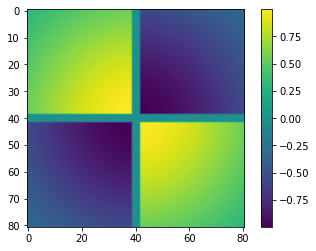

In [135]:
plt.imshow(g)
plt.colorbar()


In [136]:
# Detect peaks


peak_to_mean = np.zeros((nov.shape[0] - 2*T))
for i in range(T, nov.shape[0] - T):
    peak_to_mean[i - T] = (2*T+1)*nov[i]/np.sum(nov[i-T:i+T+1])
  
peaks = np.where(peak_to_mean > tau)

In [137]:
peak_to_mean
peaks

(array([], dtype=int64),)

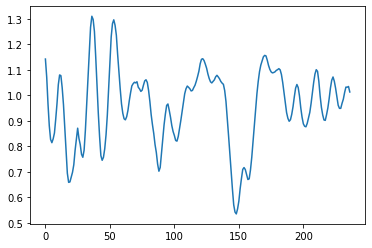

In [138]:
plt.plot(peak_to_mean)

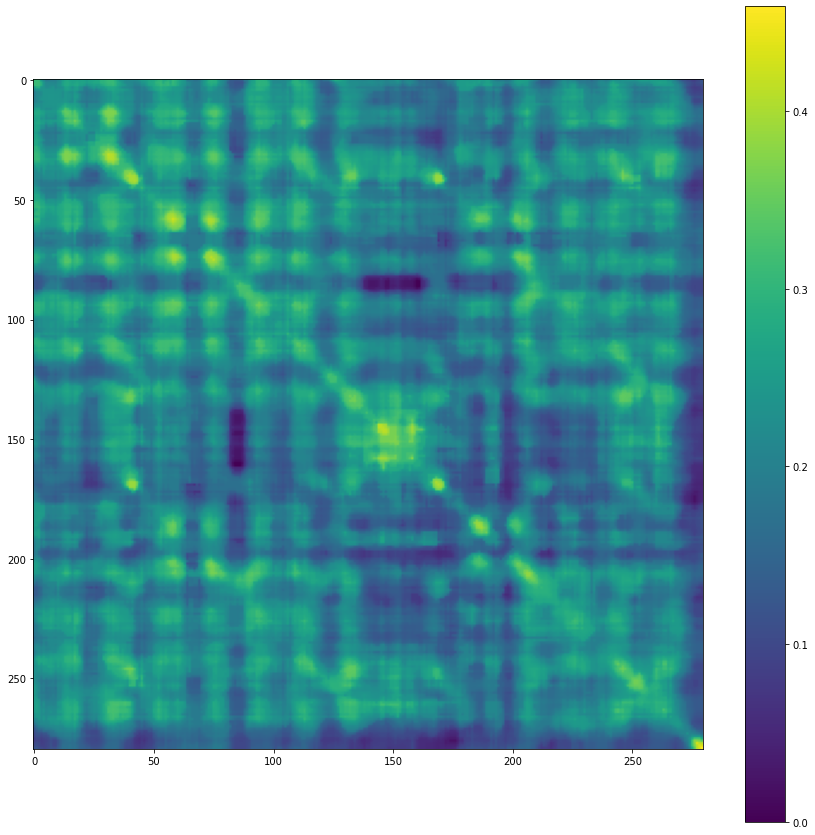

In [119]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
ssm_bis = np.max(ssm) - ssm
plt.imshow(ssm_bis[50:330,50:330])
plt.colorbar()
#plt.xlabel('$\mathtt{\delta_n,max}$', fontsize=20)
#plt.ylabel('$\mathtt{\delta_n,min}$', fontsize=20)
#plt.tick_params('both', labelsize=15)